In [9]:
import pandas as pd
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 4060 Ti


In [11]:
train_df = pd.read_csv('Data/train.csv')
test_df = pd.read_csv('Data/test.csv')
submission_df = pd.read_csv('Data/sample_submit.csv')
all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

In [3]:
train_df.head()

,target_ym,money_room,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,building_name_ruby,homes_building_name,...,drugstore_distance,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing
0,201901,13980000,206271,1,2014-06-27 21:09:41,2019-01-24 00:10:08,4,NaN,NaN,桑名市東正和台7丁目10-11,...,NaN,NaN,NaN,NaN,NaN,210101/220701/220601/230401/310501/210301/210202,NaN,NaN,NaN,NaN
1,201901,24480000,83315,1,2014-06-27 21:09:43,2019-04-03 00:10:08,4,NaN,NaN,桑名市松ノ木5丁目,...,NaN,NaN,NaN,NaN,NaN,210101/220701/220601/220801/230601/250201/2103...,NaN,NaN,NaN,NaN
2,201901,24480000,140201,1,2014-06-27 21:09:43,2020-06-06 00:10:11,4,NaN,NaN,桑名市松ノ木七丁目,...,NaN,NaN,NaN,NaN,NaN,210101/220701/220601/230401/220801/310501/2306...,NaN,NaN,NaN,NaN
3,201901,16300000,216551,1,2014-06-27 19:24:11,2019-04-26 00:10:08,4,NaN,NaN,中古戸建 知多市八幡字荒井,...,NaN,NaN,NaN,コンビニ,300.0,210101/290901/230401/210301/210401,NaN,NaN,NaN,NaN
4,201901,18800000,134968,1,2014-06-27 19:24:12,2025-09-15 02:49:23,1,ロイヤル知多寺本,NaN,ロイヤル知多寺本,...,1060.0,NaN,NaN,駅,300.0,220801/220401/250101/220701/321101/220601/2304...,NaN,NaN,NaN,NaN


In [5]:
test_df.head()

,id,target_ym,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,building_name_ruby,homes_building_name,...,drugstore_distance,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing
0,0,202301,129053,1,2014-06-27 21:09:41,2025-10-02 00:45:07,1,スペリア桑名三番館,NaN,スペリア桑名三番館,...,118.0,NaN,1077.0,桑名東方簡易郵便局,904.0,253501/220301/210101/340102/290401/220701/2206...,NaN,NaN,NaN,NaN
1,1,202301,47690,1,2014-06-27 21:09:42,2023-02-11 00:10:05,4,NaN,NaN,桑名市松並町二丁目 ミサワホーム中古住宅,...,NaN,NaN,NaN,NaN,NaN,210101/290501/210201/210301/250201,NaN,NaN,NaN,NaN
2,2,202301,130646,1,2014-06-27 19:24:11,2025-06-28 00:45:08,4,NaN,NaN,知多市南粕谷4丁目 戸建て,...,NaN,NaN,NaN,NaN,NaN,230203/210101/220401/220701/290601/220601/2901...,NaN,NaN,NaN,NaN
3,3,202301,52506,1,2014-06-27 19:24:12,2023-03-05 00:10:05,4,NaN,NaN,NaN,...,1250.0,NaN,NaN,NaN,NaN,230501/210101/220401/253401/290401/253501/2207...,NaN,NaN,NaN,NaN
4,4,202301,62277,1,2014-06-27 21:09:46,2023-04-06 00:10:05,4,NaN,NaN,赤尾台八丁目 戸建,...,NaN,NaN,533.0,NaN,NaN,210202/210101/210301/230401,NaN,NaN,NaN,NaN


In [ ]:
# 対象は object / category 型のカラム（all_df基準）
cat_cols = sorted(all_df.select_dtypes(include=['object', 'category']).columns.tolist())

rows = []
for col in cat_cols:
    total_all = len(all_df)
    miss_all = all_df[col].isnull().sum()
    non_all = total_all - miss_all
    pct_all = miss_all / total_all * 100

    if 'train_df' in globals() and col in train_df.columns:
        total_train = len(train_df)
        miss_train = train_df[col].isnull().sum()
        pct_train = miss_train / total_train * 100
    else:
        total_train = miss_train = pct_train = np.nan

    if 'test_df' in globals() and col in test_df.columns:
        total_test = len(test_df)
        miss_test = test_df[col].isnull().sum()
        pct_test = miss_test / total_test * 100
    else:
        total_test = miss_test = pct_test = np.nan

    rows.append({
        'column': col,
        'miss_all': miss_all,
        'non_missing_all': non_all,
        'total_all': total_all,
        'pct_missing_all': pct_all,
        'miss_train': miss_train,
        'total_train': total_train,
        'pct_missing_train': pct_train,
        'miss_test': miss_test,
        'total_test': total_test,
        'pct_missing_test': pct_test
    })

cat_missing_df = pd.DataFrame(rows).set_index('column').sort_values('pct_missing_all', ascending=False)

# 表示（必要なら .head() を変更して表示行数を調整）
pd.options.display.max_rows = 200
display(cat_missing_df)

,miss_all,non_missing_all,total_all,pct_missing_all,miss_train,total_train,pct_missing_train,miss_test,total_test,pct_missing_test
column,,,,,,,,,,
money_hoshou_company,476320,41,476361,99.991393,363924,363924,100.000000,112396,112437,99.963535
reform_etc,475829,532,476361,99.888320,363495,363924,99.882118,112334,112437,99.908393
reform_place_other,475273,1088,476361,99.771602,363055,363924,99.761214,112218,112437,99.805224
reform_place,475088,1273,476361,99.732766,362888,363924,99.715325,112200,112437,99.789215
reform_common_area,473390,2971,476361,99.376313,361621,363924,99.367176,111769,112437,99.405890
money_sonota_str3,472125,4236,476361,99.110758,360842,363924,99.153120,111283,112437,98.973647
reform_exterior_other,470121,6240,476361,98.690069,359449,363924,98.770348,110672,112437,98.430232
reform_wet_area_other,467158,9203,476361,98.068062,357233,363924,98.161429,109925,112437,97.765860
money_sonota_str2,462965,13396,476361,97.187847,354206,363924,97.329662,108759,112437,96.728835


In [10]:
# 日本語フォントの設定（Windows環境）
import matplotlib
matplotlib.rcParams['font.family'] = 'MS Gothic'  # Windows標準の日本語フォント
# 負の符号の文字化けを防ぐ設定
matplotlib.rcParams['axes.unicode_minus'] = False

# money_roomと他の変数の相関関係を確認
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 数値変数のみを抽出
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

# money_roomとの相関係数を計算
correlations = train_df[numeric_cols].corr()['money_room'].sort_values(ascending=False)

print("=" * 60)
print("money_roomとの相関係数（降順）")
print("=" * 60)
print(correlations)
print("\n")

# 相関が高い変数（絶対値が0.1以上）を表示
high_corr = correlations[abs(correlations) >= 0.1].drop('money_room')
print("=" * 60)
print("相関係数の絶対値が0.1以上の変数")
print("=" * 60)
print(high_corr)


money_roomとの相関係数（降順）
money_room              1.000000
traffic_car             0.996619
year_built              0.332626
parking_money           0.308021
room_floor              0.295546
                          ...   
school_ele_code              NaN
school_jun_code              NaN
money_hoshou_company         NaN
free_rent_duration           NaN
free_rent_gen_timing         NaN
Name: money_room, Length: 105, dtype: float64


相関係数の絶対値が0.1以上の変数
traffic_car                   0.996619
year_built                    0.332626
parking_money                 0.308021
room_floor                    0.295546
unit_area_max                 0.265837
madori_kind_all               0.259677
room_kaisuu                   0.244438
floor_count                   0.223519
lon                           0.163669
el                            0.143111
management_form               0.140943
unit_count                    0.133704
land_mochibun_a               0.124236
management_association_flg    0.122607
refo

In [16]:
# LightGBMのインポート
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


In [17]:
# データの準備
# 目的変数と特徴量の分離
y = train_df['money_room'].copy()
X = train_df.drop('money_room', axis=1).copy()

# testデータからidを取得（後で使用）
test_ids = test_df['id'].copy() if 'id' in test_df.columns else None
X_test = test_df.drop('id', axis=1).copy() if 'id' in test_df.columns else test_df.copy()

print(f"訓練データの形状: {X.shape}")
print(f"テストデータの形状: {X_test.shape}")
print(f"目的変数の形状: {y.shape}")


訓練データの形状: (363924, 148)
テストデータの形状: (112437, 148)
目的変数の形状: (363924,)


In [23]:
# カテゴリ変数の処理（文字列型のカテゴリ変数を数値に変換）
# LightGBMはカテゴリ変数を扱えますが、文字列の場合は数値に変換する必要があります

# XとX_testのカラムを揃える（共通のカラムのみを使用）
common_cols = list(set(X.columns) & set(X_test.columns))
print(f"共通カラム数: {len(common_cols)}")
print(f"Xのみのカラム: {set(X.columns) - set(X_test.columns)}")
print(f"X_testのみのカラム: {set(X_test.columns) - set(X.columns)}")

# 共通カラムのみを使用
X = X[common_cols].copy()
X_test = X_test[common_cols].copy()

print(f"\n調整後の訓練データの形状: {X.shape}")
print(f"調整後のテストデータの形状: {X_test.shape}")

# オブジェクト型（文字列）のカラムを取得（両方のデータフレームから）
categorical_cols_X = set(X.select_dtypes(include=['object']).columns)
categorical_cols_X_test = set(X_test.select_dtypes(include=['object']).columns)
categorical_cols = list(categorical_cols_X | categorical_cols_X_test)  # 和集合

print(f"\nカテゴリ変数の数: {len(categorical_cols)}")
print(f"カテゴリ変数: {categorical_cols[:10]}...")  # 最初の10個を表示

# カテゴリ変数をLabel Encoding（特徴量を加工せず、そのまま使う方針）
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_cols:
    if col not in X.columns:
        # Xに存在しない場合は、X_testから削除（または0で埋める）
        print(f"警告: {col}はXに存在しません。X_testから削除します。")
        X_test = X_test.drop(col, axis=1)
        continue
    if col not in X_test.columns:
        # X_testに存在しない場合は、Xから削除（または0で埋める）
        print(f"警告: {col}はX_testに存在しません。Xから削除します。")
        X = X.drop(col, axis=1)
        continue
    
    le = LabelEncoder()
    # 訓練データとテストデータを結合してエンコーディング（一貫性を保つため）
    combined = pd.concat([X[col], X_test[col]], axis=0)
    combined = combined.astype(str).fillna('missing')
    le.fit(combined)
    X[col] = le.transform(X[col].astype(str).fillna('missing'))
    X_test[col] = le.transform(X_test[col].astype(str).fillna('missing'))
    label_encoders[col] = le

# 最終的なカテゴリ変数のリストを更新（実際にエンコーディングされたもののみ）
categorical_cols = [col for col in categorical_cols if col in X.columns and col in X_test.columns]

print(f"\nカテゴリ変数のエンコーディング完了")
print(f"最終的なカテゴリ変数の数: {len(categorical_cols)}")

# データ型の確認（すべて数値型になっているか確認）
print(f"\nXのデータ型確認:")
print(f"  オブジェクト型のカラム: {X.select_dtypes(include=['object']).columns.tolist()}")
print(f"X_testのデータ型確認:")
print(f"  オブジェクト型のカラム: {X_test.select_dtypes(include=['object']).columns.tolist()}")

# カテゴリカル変数のカーディナリティを確認
print("\nカテゴリカル変数のユニークな値の数:")
for col in categorical_cols:
    n_unique = X[col].nunique()
    print(f"  {col}: {n_unique}")
    if n_unique > 16000: # GPUのbinの上限の目安
        print(f"    -> ★★★ {col} はカーディナリティが非常に高いです ★★★")

共通カラム数: 148
Xのみのカラム: set()
X_testのみのカラム: set()

調整後の訓練データの形状: (363924, 148)
調整後のテストデータの形状: (112437, 148)

カテゴリ変数の数: 0
カテゴリ変数: []...

カテゴリ変数のエンコーディング完了
最終的なカテゴリ変数の数: 0

Xのデータ型確認:
  オブジェクト型のカラム: []
X_testのデータ型確認:
  オブジェクト型のカラム: []

カテゴリカル変数のユニークな値の数:


In [24]:
# 訓練データと検証データに分割
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"訓練データ: {X_train.shape}, 検証データ: {X_val.shape}")
print(f"訓練データの目的変数: {y_train.shape}, 検証データの目的変数: {y_val.shape}")


訓練データ: (291139, 148), 検証データ: (72785, 148)
訓練データの目的変数: (291139,), 検証データの目的変数: (72785,)


In [40]:
# LightGBMのデータセット作成
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, categorical_feature=categorical_cols)

# LightGBMのパラメータ設定
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': 42,
    'device': 'gpu', # GPUを使用する設定
    'max_bin': 200   # カテゴリの最大数を増やす
}

print("LightGBMパラメータ:")
for key, value in params.items():
    print(f"  {key}: {value}")


LightGBMパラメータ:
  objective: regression
  metric: rmse
  boosting_type: gbdt
  num_leaves: 31
  learning_rate: 0.05
  feature_fraction: 0.9
  bagging_fraction: 0.8
  bagging_freq: 5
  verbose: 0
  random_state: 42
  device: gpu
  max_bin: 200


In [41]:
# モデルの学習
print("モデルの学習を開始します...")
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

print("学習完了")


モデルの学習を開始します...
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.6621e+06	valid's rmse: 8.8173e+06
[200]	train's rmse: 7.54532e+06	valid's rmse: 7.83358e+06
[300]	train's rmse: 6.95724e+06	valid's rmse: 7.33199e+06
[400]	train's rmse: 6.58027e+06	valid's rmse: 7.05289e+06
[500]	train's rmse: 6.30732e+06	valid's rmse: 6.85183e+06
[600]	train's rmse: 6.09888e+06	valid's rmse: 6.70828e+06
[700]	train's rmse: 5.92332e+06	valid's rmse: 6.59536e+06
[800]	train's rmse: 5.76964e+06	valid's rmse: 6.50108e+06
[900]	train's rmse: 5.63661e+06	valid's rmse: 6.41944e+06
[1000]	train's rmse: 5.51175e+06	valid's rmse: 6.34017e+06
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.51175e+06	valid's rmse: 6.34017e+06
学習完了


In [43]:
# 検証データでの予測と評価
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)

# 評価指標の計算
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)

# MAPE（Mean Absolute Percentage Error）の計算
# 実際の値が0でない場合のみ計算（0除算を避けるため）
mask = y_val != 0
if mask.sum() > 0:
    mape = np.mean(np.abs((y_val[mask] - y_val_pred[mask]) / y_val[mask])) * 100
    zero_count = (~mask).sum()
    total_count = len(y_val)
else:
    mape = np.nan
    zero_count = len(y_val)
    total_count = len(y_val)

print("=" * 60)
print("検証データでの評価結果")
print("=" * 60)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
if not np.isnan(mape):
    print(f"MAPE: {mape:.2f}%")
    if zero_count > 0:
        print(f"  ※MAPE計算から除外したデータ（実際の値が0）: {zero_count}件 / {total_count}件")
else:
    print(f"MAPE: 計算不可（実際の値がすべて0のため）")
print(f"\n目的変数の統計:")
print(f"  平均: {y_val.mean():,.2f}")
print(f"  標準偏差: {y_val.std():,.2f}")
print(f"  最小値: {y_val.min():,.2f}")
print(f"  最大値: {y_val.max():,.2f}")


検証データでの評価結果
RMSE: 6,340,173.83
MAE: 4,092,865.72
MAPE: 19.25%

目的変数の統計:
  平均: 25,922,720.27
  標準偏差: 18,466,401.39
  最小値: 4,900,000.00
  最大値: 188,000,000.00


特徴量重要度（上位20）
                  feature    importance
108            house_area  1.320053e+20
74                  post1  1.314145e+20
87             year_built  1.126349e+20
4           money_kyoueki  6.574376e+19
125               addr1_2  4.390514e+19
25                    lat  2.027787e+19
88        madori_kind_all  1.948500e+19
32                    lon  1.948229e+19
57                     nl  1.773603e+19
124          full_address  1.751569e+19
114           floor_count  1.469887e+19
51                     el  1.363042e+19
3               unit_area  1.334777e+19
40     snapshot_land_area  1.153785e+19
105        walk_distance2  1.036601e+19
141         parking_money  1.002442e+19
68   building_create_date  7.702655e+18
45            rosen_name1  7.660936e+18
131        walk_distance1  6.516996e+18
22             room_floor  5.363703e+18


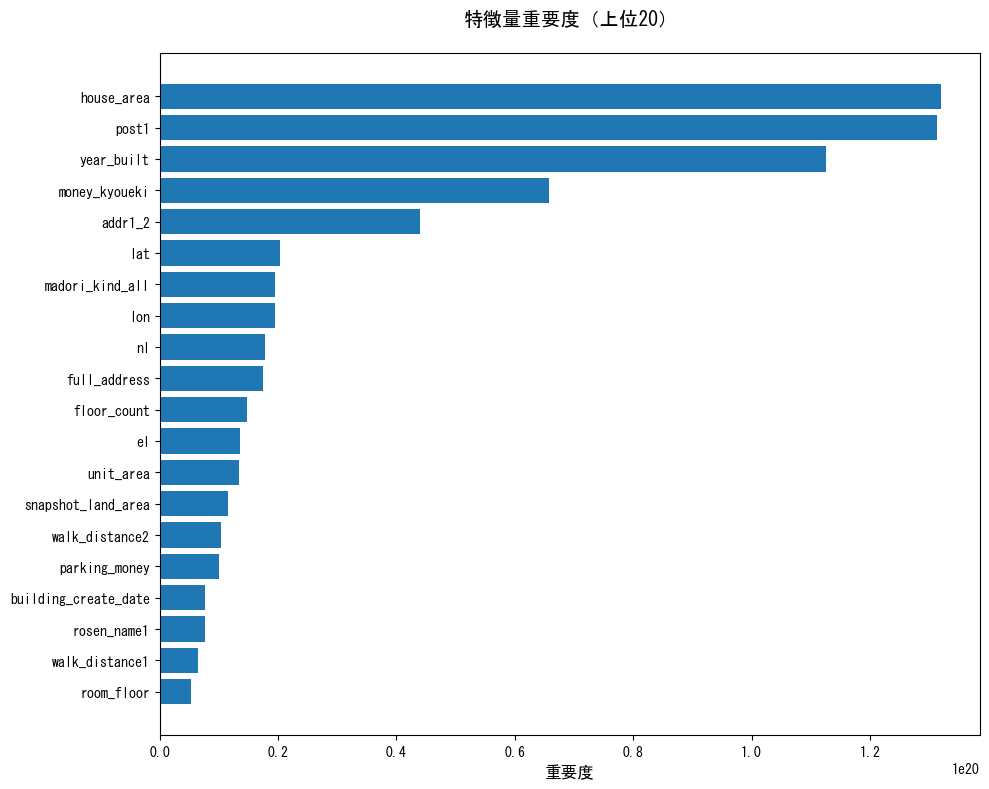

In [44]:
# 特徴量重要度の可視化
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# 上位20特徴量を表示
print("=" * 60)
print("特徴量重要度（上位20）")
print("=" * 60)
print(feature_importance.head(20))

# 特徴量重要度を可視化
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('重要度', fontsize=12)
plt.title('特徴量重要度（上位20）', fontsize=14, pad=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [45]:
# テストデータでの予測
print("テストデータでの予測を開始します...")

# XとX_testのカラム順序を揃える（重要！）
X_test = X_test[X.columns]

# データ型の最終確認
print(f"Xのカラム数: {len(X.columns)}")
print(f"X_testのカラム数: {len(X_test.columns)}")
print(f"カラムが一致しているか: {list(X.columns) == list(X_test.columns)}")

# オブジェクト型のカラムが残っていないか確認
obj_cols_X = X.select_dtypes(include=['object']).columns.tolist()
obj_cols_X_test = X_test.select_dtypes(include=['object']).columns.tolist()
if obj_cols_X:
    print(f"警告: Xにオブジェクト型のカラムが残っています: {obj_cols_X}")
if obj_cols_X_test:
    print(f"警告: X_testにオブジェクト型のカラムが残っています: {obj_cols_X_test}")

y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

print(f"予測値の統計:")
print(f"  平均: {y_test_pred.mean():,.2f}")
print(f"  標準偏差: {y_test_pred.std():,.2f}")
print(f"  最小値: {y_test_pred.min():,.2f}")
print(f"  最大値: {y_test_pred.max():,.2f}")
print(f"\n予測完了: {len(y_test_pred)}件")


テストデータでの予測を開始します...
Xのカラム数: 148
X_testのカラム数: 148
カラムが一致しているか: True
予測値の統計:
  平均: 28,567,805.57
  標準偏差: 17,680,197.59
  最小値: -1,464,744.73
  最大値: 172,217,642.02

予測完了: 112437件


In [47]:
# 提出用ファイルの作成（sample_submit.csvの形式に合わせる）
if test_ids is not None:
    # idを6桁のゼロパディング形式に変換
    id_formatted = test_ids.astype(str).str.zfill(6)
    submission = pd.DataFrame({
        'id': id_formatted,
        'money_room': y_test_pred.astype(int)  # 整数形式に変換
    })
else:
    # idカラムがない場合はインデックスを使用（6桁のゼロパディング）
    id_formatted = pd.Series(range(len(y_test_pred))).astype(str).str.zfill(6)
    submission = pd.DataFrame({
        'id': id_formatted,
        'money_room': y_test_pred.astype(int)  # 整数形式に変換
    })

# 提出ファイルを保存（sample_submit.csvと同じ形式）
submission.to_csv('submission/submission.csv', index=False, header=False)
print("=" * 60)
print("提出ファイルを保存しました: submission.csv")
print("=" * 60)
print("ファイル形式: id（6桁ゼロパディング）,money_room（整数）")
print("\n最初の10行:")
print(submission.head(10).to_string(index=False))
print(f"\n提出ファイルの形状: {submission.shape}")

提出ファイルを保存しました: submission.csv
ファイル形式: id（6桁ゼロパディング）,money_room（整数）

最初の10行:
    id  money_room
000000    18176921
000001    24506840
000002    19235228
000003    26536255
000004    17260658
000005    32048222
000006    14845936
000007    27383008
000008    30476921
000009    30634079

提出ファイルの形状: (112437, 2)
